In [1]:
import sys, os
sys.path.append(os.path.abspath('../'))

In [2]:
from src.utils.flow import *
from src.utils.flow_calculations import *
from src.utils.restoration import *
from src.utils.truncated_packet import *
from src.operations.size_perturbation_logic import *
from src.operations.timing_perturbation_logic import *
from src.operations.calculate_fitness import *

In [3]:
capture = "botnet-capture-20110811-neris" # test file


pcap_file_path = f'../data/raw/{capture}.pcap'

truncated_packets = create_truncated_packets_from_pcap(pcap_file_path)
print(f"Total packets loaded: {len(truncated_packets)}")

truncated_packets = assign_flow_ids_to_packets(truncated_packets)

# funkcja na sprawdzenie ile flow ids zostalo przypisane i jaki jest ich rozklad w zaleznosci od wielkosci danego flow
# oryg 21756




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [4]:
truncated_packets[1]
# dlaczego id jest 5, a nie 1

TruncatedPacket(packet_id=5, timestamp=1313051628.478979, size=62, pseudo_hash='-9889224071550260821', flow_id=1, direction='2', src_ip=147.32.84.171, fragmented=0, tcp=1, udp=0, fin=0, syn=1, rst=0, ack=1, psh=0, urg=0)

In [5]:
from collections import Counter

def analyze_flows(packets):
    # Tworzenie słownika do liczenia pakietów dla każdego flow_id
    flow_counts = Counter(packet.flow_id for packet in packets)
    print(len(flow_counts))
    
    
    # Wypisywanie liczby pakietów dla każdego flow_id
    for flow_id, count in flow_counts.items():
        print(f"Flow ID: {flow_id}, Number of Packets: {count}")
    
    # Zwracanie słownika z liczbami pakietów dla każdego flow_id
    return flow_counts


calculated_flows = analyze_flows(truncated_packets)

5395
Flow ID: 1, Number of Packets: 21
Flow ID: 2, Number of Packets: 27
Flow ID: 10, Number of Packets: 124
Flow ID: 16, Number of Packets: 22
Flow ID: 17, Number of Packets: 10
Flow ID: 18, Number of Packets: 25
Flow ID: 21, Number of Packets: 35
Flow ID: 22, Number of Packets: 157
Flow ID: 24, Number of Packets: 28
Flow ID: 27, Number of Packets: 54
Flow ID: 28, Number of Packets: 21
Flow ID: 29, Number of Packets: 159
Flow ID: 30, Number of Packets: 19
Flow ID: 31, Number of Packets: 6
Flow ID: 32, Number of Packets: 6
Flow ID: 33, Number of Packets: 16
Flow ID: 34, Number of Packets: 15
Flow ID: 35, Number of Packets: 457
Flow ID: 36, Number of Packets: 124
Flow ID: 37, Number of Packets: 56
Flow ID: 38, Number of Packets: 10
Flow ID: 39, Number of Packets: 139
Flow ID: 40, Number of Packets: 10
Flow ID: 41, Number of Packets: 24
Flow ID: 42, Number of Packets: 10
Flow ID: 43, Number of Packets: 18
Flow ID: 44, Number of Packets: 77
Flow ID: 45, Number of Packets: 56
Flow ID: 46, 

In [6]:
import pandas as pd

def read_and_sum_from_csv(file_path):
    # Wczytanie danych z pliku CSV
    df = pd.read_csv(file_path)
    
    # Sumowanie kolumn tot_bwd_pkts i tot_fwd_pkts
    df['total_packets'] = df['tot_bwd_pkts'] + df['tot_fwd_pkts']
    
    return df['total_packets']


# Przykład użycia:
file_path = f'../data/processed/{capture}_orig_flows.csv'
csv_flows = read_and_sum_from_csv(file_path)


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def compare_flows(calculated_flows, csv_flows):
    # Znalezienie wspólnych flow_id
    common_flows = set(calculated_flows.keys()).intersection(set(csv_flows.index))
    
    if not common_flows:
        print("Nie znaleziono wspólnych flow_id do porównania.")
        return

    # Porównanie liczby pakietów dla wspólnych flow_id
    differences = {flow_id: calculated_flows[flow_id] - csv_flows[flow_id] for flow_id in common_flows}

    # Rysowanie histogramu różnic
    plt.figure(figsize=(10, 6))
    plt.bar(differences.keys(), differences.values(), color='red')
    plt.xlabel('Flow ID')
    plt.ylabel('Difference in Packet Count')
    plt.title('Difference in Packet Count Between Methods')
    plt.xticks(list(differences.keys()), rotation=45)
    plt.tight_layout()
    plt.show()

    # Wypisanie różnic
    for flow_id, diff in differences.items():
        print(f"Flow ID {flow_id}: Różnica w liczbie pakietów = {diff}")


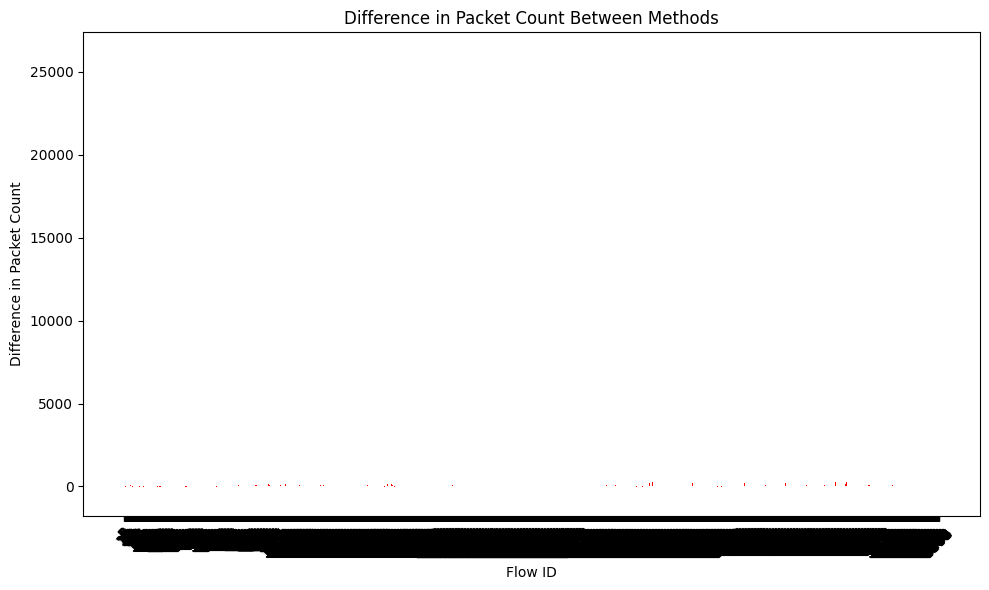

Flow ID 1: Różnica w liczbie pakietów = 18
Flow ID 2: Różnica w liczbie pakietów = 5
Flow ID 3: Różnica w liczbie pakietów = -5
Flow ID 4: Różnica w liczbie pakietów = 0
Flow ID 5: Różnica w liczbie pakietów = -4
Flow ID 6: Różnica w liczbie pakietów = 6
Flow ID 7: Różnica w liczbie pakietów = -8
Flow ID 8: Różnica w liczbie pakietów = -19
Flow ID 9: Różnica w liczbie pakietów = 14
Flow ID 10: Różnica w liczbie pakietów = 123
Flow ID 11: Różnica w liczbie pakietów = -32
Flow ID 12: Różnica w liczbie pakietów = 0
Flow ID 13: Różnica w liczbie pakietów = 3
Flow ID 14: Różnica w liczbie pakietów = 9
Flow ID 15: Różnica w liczbie pakietów = 9
Flow ID 16: Różnica w liczbie pakietów = 21
Flow ID 17: Różnica w liczbie pakietów = -44
Flow ID 18: Różnica w liczbie pakietów = 23
Flow ID 19: Różnica w liczbie pakietów = -3
Flow ID 20: Różnica w liczbie pakietów = -12
Flow ID 21: Różnica w liczbie pakietów = 33
Flow ID 22: Różnica w liczbie pakietów = 0
Flow ID 23: Różnica w liczbie pakietów = 119

In [8]:
compare_flows(calculated_flows, csv_flows)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np  # Potrzebne do operacji na tablicach

def plot_histograms(calculated_flows, csv_flows):
    # Pobranie wartości ilości pakietów dla każdego flow_id z obu zbiorów danych
    calc_packets = [count for flow_id, count in calculated_flows.items()]
    csv_packets = [csv_flows[flow_id] for flow_id in calculated_flows.keys() if flow_id in csv_flows]

    # Tworzenie histogramów
    plt.figure(figsize=(12, 8))

    # Histogram dla danych z Pythona
    bins = np.histogram(np.hstack((calc_packets, csv_packets)), bins=40000)[1]  # Definiowanie wspólnych przedziałów dla obu zbiorów danych
    plt.hist(calc_packets, bins=bins, alpha=0.5, label='Calculated Flows', color='blue')

    # Histogram dla danych z CSV
    plt.hist(csv_packets, bins=bins, alpha=0.5, label='CSV Flows', color='green')

    # Dodanie legendy, tytułu i etykiet
    plt.yscale('log')  # Zmiana skali osi Y na logarytmiczną
    plt.xlabel('Number of Packets')
    plt.ylabel('Frequency (log scale)')
    plt.title('Comparison of Packet Counts in Flows')
    plt.legend()

    plt.xlim(0, 100)

    # Wyświetlenie wykresu
    plt.show()

# Przykład użycia
plot_histograms(calculated_flows, csv_flows)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histograms(calculated_flows, csv_flows, num_bins=20):
    # Pobranie wartości ilości pakietów dla każdego flow_id z obu zbiorów danych
    calc_packets = [count for flow_id, count in calculated_flows.items()]
    csv_packets = [csv_flows[flow_id] for flow_id in calculated_flows.keys() if flow_id in csv_flows]

    # Tworzenie histogramów
    plt.figure(figsize=(12, 8))

    # Histogram dla danych z Pythona
    plt.hist(calc_packets, bins=num_bins, range=(0, 1000), alpha=0.5, label='Calculated Flows', color='blue')

    # Histogram dla danych z CSV
    plt.hist(csv_packets, bins=num_bins, range=(0, 1000), alpha=0.5, label='CSV Flows', color='green')

    # Dodanie legendy, tytułu i etykiet
    plt.yscale('log')  # Zmiana skali osi Y na logarytmiczną
    plt.xlabel('Number of Packets')
    plt.ylabel('Frequency (log scale)')
    plt.title('Comparison of Packet Counts in Flows')
    plt.legend()

    # Ustawienie limitów osi X
    plt.xlim(0, 1000)

    # Wyświetlenie wykresu
    plt.show()

# Przykład użycia z różną gęstością słupków
plot_histograms(calculated_flows, csv_flows, num_bins=1000)  # Możesz zmieniać 'num_bins' aby regulować gęstość słupków


In [ ]:
# UNDER SAMPLE TESTING

In [ ]:
#truncated_packets = undersample_flows_with_distribution(truncated_packets, 100)